#  Прогнозирование заказов такси

# Описание задачи

У компании имеются данные о заказах такси в аэропортах. С помощью этих данных необходимо спрогнозировать количество заказов такси на следующий час. Нужно построить модель машинного обучения для данного прогноза. Значение метрики RMSE на тестовой выборке должно быть не больше 48.

# План работы

1. Подготовка данных
2. Анализ данных
3. Обучение
    1. Модель линейной регрессии LinearRegression
    2. Модель решающего дерева DecisionTreeRegressor
    3. Модель случайного леса RandomForestRegressor
    4. Модель CatBoostRegressor
4. Тестирование
    1. Модель линейной регрессии
    2. Модель решающего дерева
    3. Модель случайного леса
    4. Модель CatBoostRegressor
    5. Вывод
5. Вывод

# Описание данных

num_orders - число заказов

## Подготовка данных

In [129]:
# Импорт библиотек и функций
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor

In [130]:
# Чтение таблицы данных
data = pd.read_csv('datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [131]:
#Сортировка записей в порядке возрастания индекса
data.sort_index(inplace=True)

In [132]:
#Ресемплирование по одному часу
data = data.resample('1H').sum()

In [133]:
#Просмотр таблицы и оценка ее размеров
data

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


## Анализ данных

In [134]:
#Создание объекта структуры DecomposeResult для анализа тренда и сезонности
decomposed = seasonal_decompose(data) 

In [135]:
#Скользящее среднее
data['rolling_mean'] = data['num_orders'].rolling(24).mean()

In [136]:
#Скользящее стандартное отклонение
data['rolling_std'] = data['num_orders'].rolling(24).std()

Text(0, 0.5, 'Число заказов')

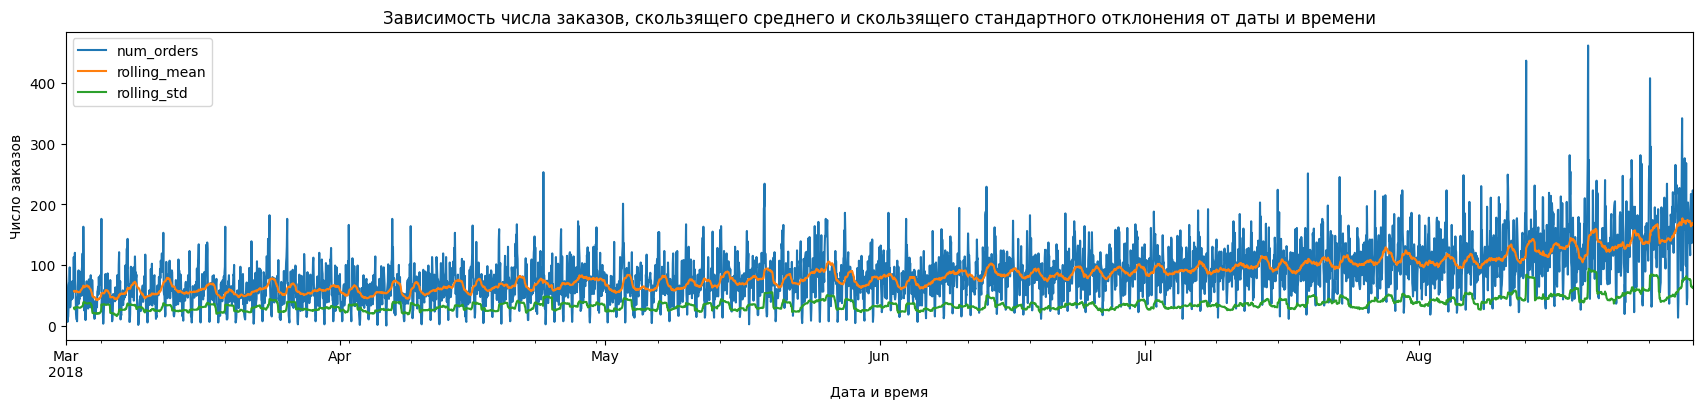

In [137]:
#Построение графика датасета
figsize = (21, 4)
data.plot(figsize = figsize)
plt.title('Зависимость числа заказов, скользящего среднего и скользящего стандартного отклонения от даты и времени')
plt.xlabel('Дата и время')
plt.ylabel('Число заказов')

Text(0, 0.5, 'Тренд')

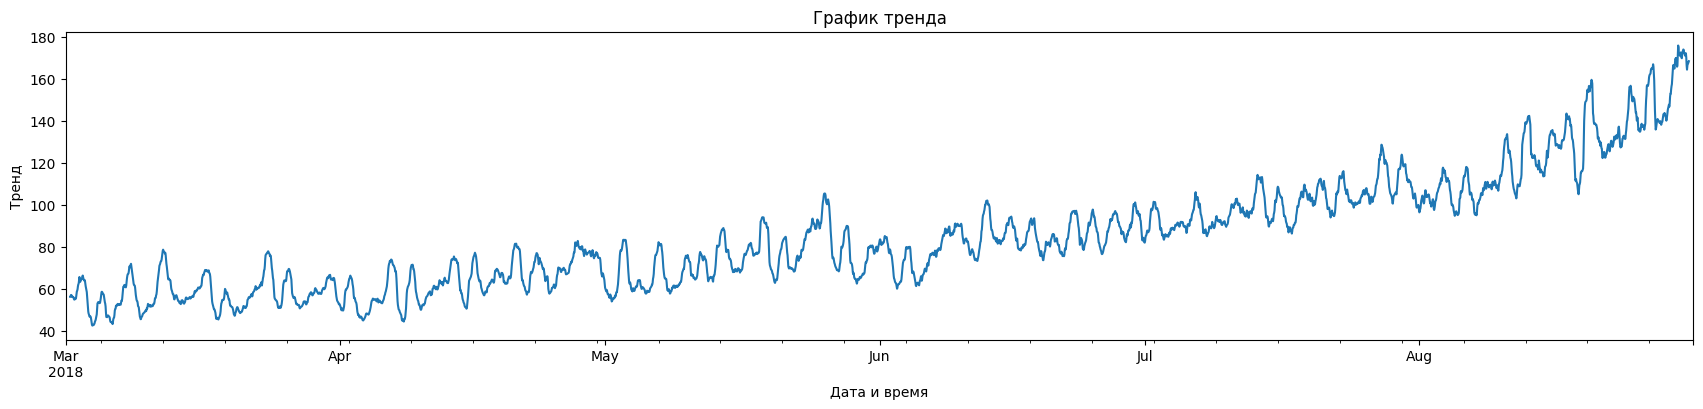

In [138]:
#График тренда
decomposed.trend.plot(figsize = figsize)
plt.title('График тренда')
plt.xlabel('Дата и время')
plt.ylabel('Тренд')

Из данных двух графиков видно, что ряд является нестационарным. Начиная с марта 2018 года наблюдается тенденция роста числа заказов.

Text(0, 0.5, 'Сезонность')

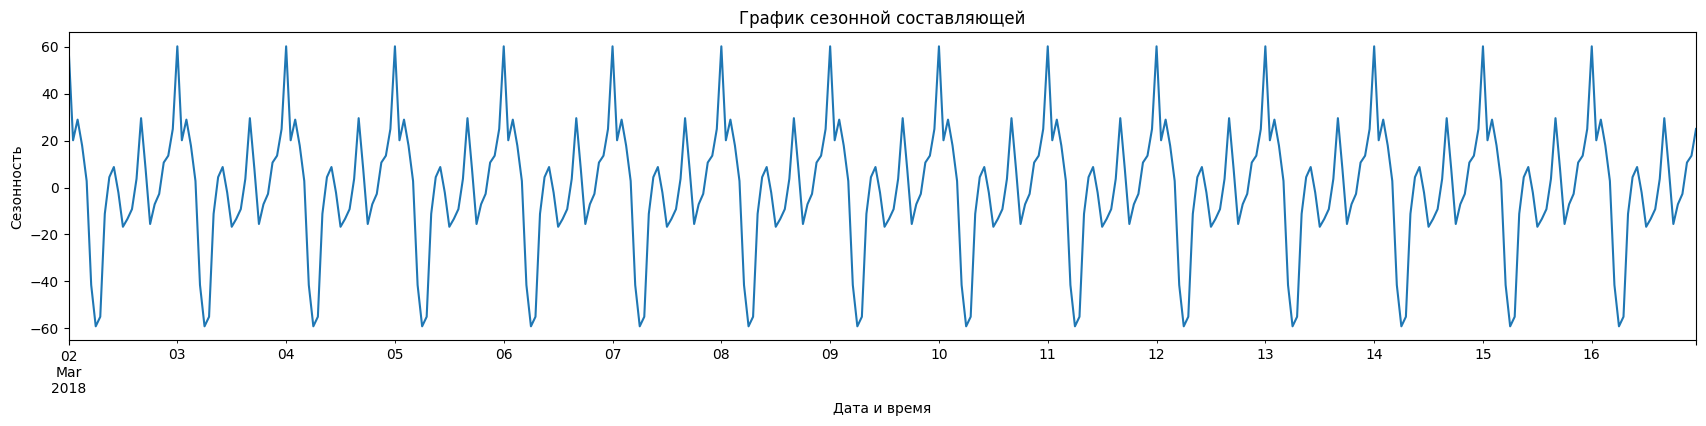

In [139]:
#График сезонной составляющей
figsize = (21, 4)
decomposed.seasonal['2018-03-02':'2018-03-16'].plot(figsize = figsize)
plt.title('График сезонной составляющей')
plt.xlabel('Дата и время')
plt.ylabel('Сезонность')

Из предыдущего графика видно, что сезонных изменений в течении месяца не наблюдается. Однако такие изменения прослеживаются в течении суток. Для более подробного изучения сезонности построим график сезонной составляющей за 2 суток.

Text(0, 0.5, 'Сезонность')

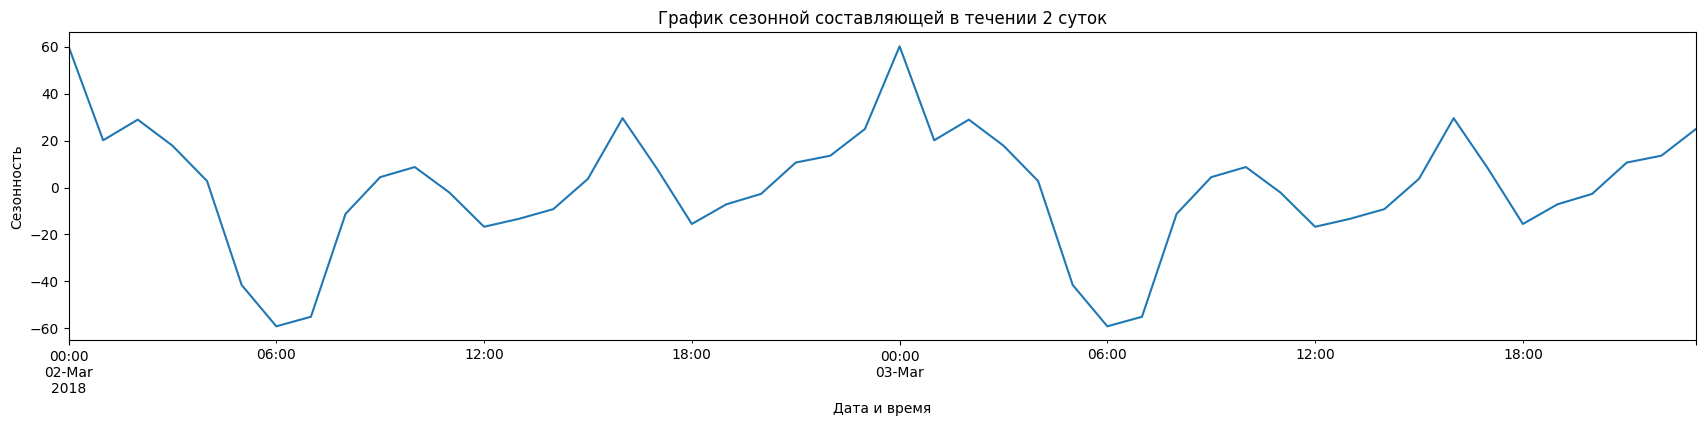

In [140]:
# График сезонной составляющей в течении 2 суток
figsize = (21, 4)
decomposed.seasonal['2018-03-02':'2018-03-03'].plot(figsize = figsize)
plt.title('График сезонной составляющей в течении 2 суток')
plt.xlabel('Дата и время')
plt.ylabel('Сезонность')

Из предыдущего графика видно, что в течении суток прослеживаются циклично повторяющиеся изменения. Минимальное число заказов наблюдается в районе 6.00, а максимальное - в районе 00.00.

Text(0, 0.5, 'Остаток декомпозиции')

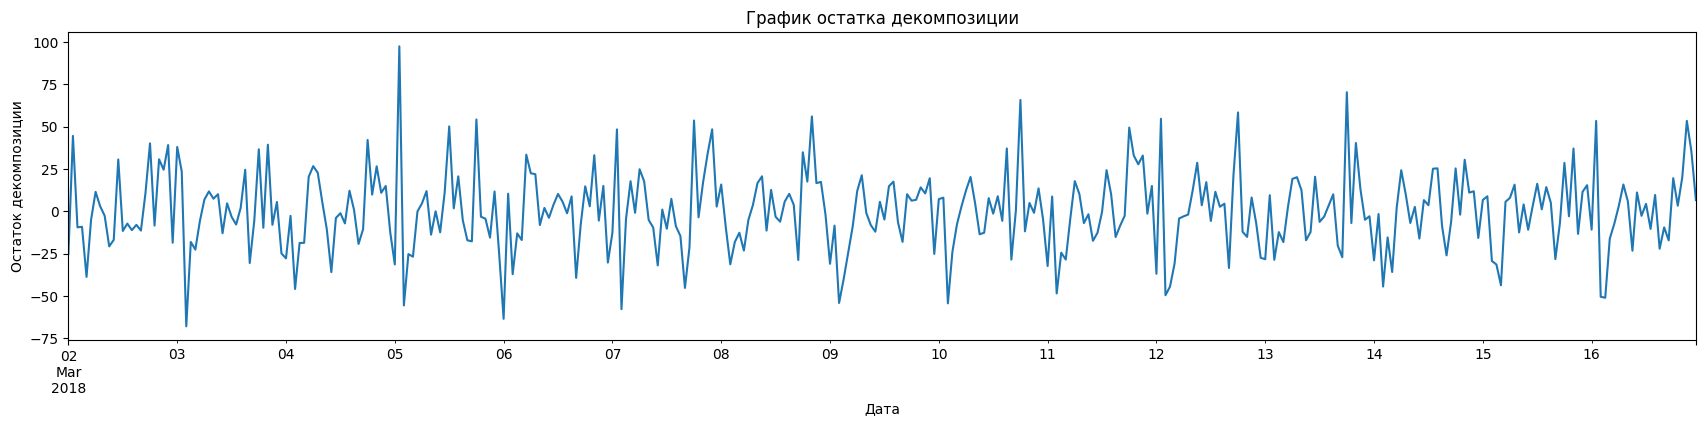

In [141]:
#График остатка декомпозиции
decomposed.resid['2018-03-02':'2018-03-16'].plot(figsize = figsize)
plt.title('График остатка декомпозиции')
plt.xlabel('Дата')
plt.ylabel('Остаток декомпозиции')

Text(0, 0.5, 'Остаток декомпозиции')

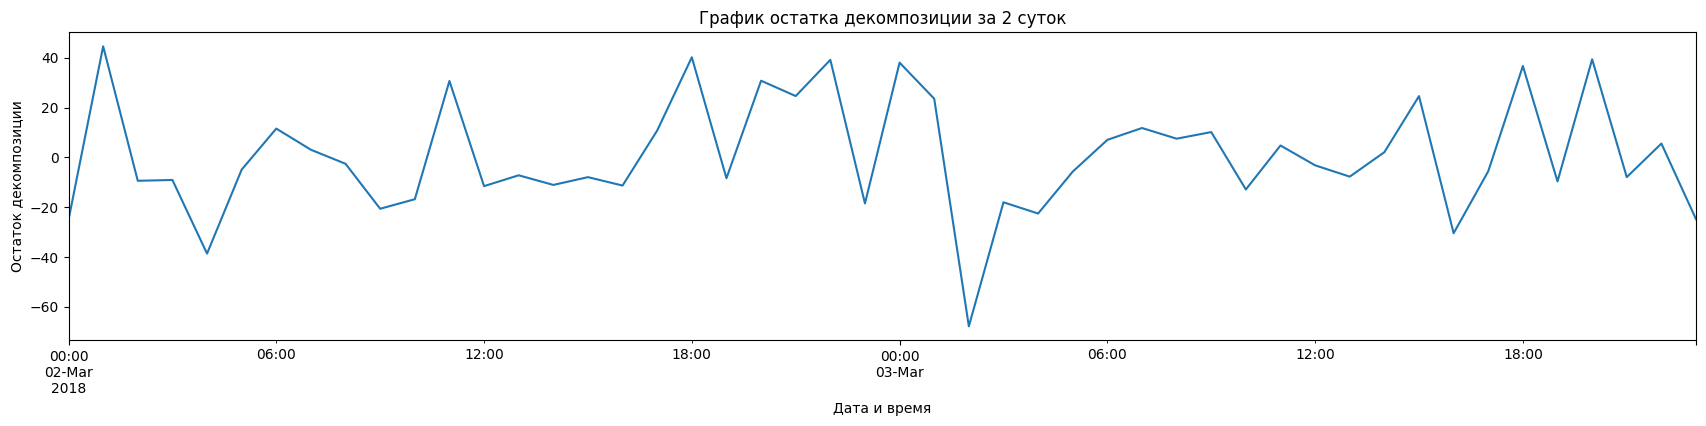

In [142]:
#График остатка декомпозиции за 2 суток
decomposed.resid['2018-03-02':'2018-03-03'].plot(figsize = figsize)
plt.title('График остатка декомпозиции за 2 суток')
plt.xlabel('Дата и время')
plt.ylabel('Остаток декомпозиции')

Остаток декомпозиции говорит о количестве шума в данных. Если его значения близки к нулю,то это указывает на то, что сезонный и трендовый компоненты близки к точному описанию временного ряда. Большие же значения остатка указывают на то,что в данных присутствует шум.

Далее для более качественного обучения моделей проанализируем ряд на наличие аномальных значений, то есть выбросов. Сделаем это с помощью "ящика с усами".

<Axes: >

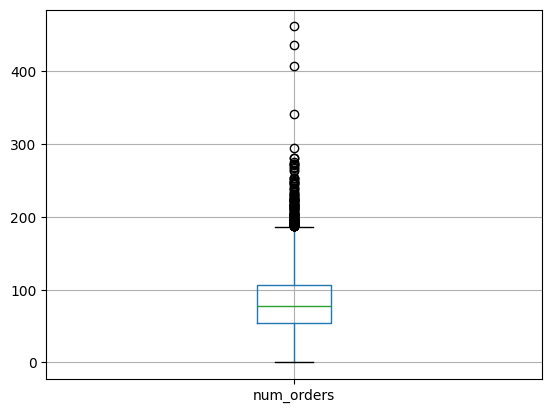

In [143]:
#Построение графика "Ящик с усами"
pd.DataFrame(data['num_orders']).boxplot()

Из построенного графика видно наличие множества аномальных значений. Для лучшего обучения моделей их необходимо удалить.

In [144]:
#Определим квартили, мехквартильный размах и верхнюю границу, за пределами которой будут выбросы
Q1 = data['num_orders'].quantile(0.25)
Q3 = data['num_orders'].quantile(0.75)

IQR = Q3 - Q1

upper=Q3+1.5*IQR
upper

186.5

In [145]:
#Количество выбросов
data[data['num_orders']>upper]['num_orders'].count()

121

In [146]:
#Удалим выбросы
data = data.drop(data[data['num_orders']>upper].index, axis=0)

## Обучение

Задача прогнозирования временного ряда включает в себя создание календарных признаков, признаков "отстающие значения" и признака "скользящее среднее":

In [147]:
#Функция создания признаков
def make_features(data, max_lag, rolling_mean_size):    
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

### Модель линейной регрессии LinearRegression

In [148]:
#Создание признаков для текущей модели
make_features(data, 30, 1)

In [149]:
#Создание обучающей и тестовой выборок для текущей модели
train, test = train_test_split(data, shuffle=False, test_size=0.1)
train = train.dropna()
features_train_lr = train.drop(['num_orders'], axis=1)
features_test_lr = test.drop(['num_orders'], axis=1)
target_train_lr = train['num_orders']
target_test_lr = test['num_orders']

In [150]:
#Создание объекта модели линейной регрессии
model_lr = LinearRegression()

In [151]:
#Обучение модели линейной регрессии
model_lr.fit(features_train_lr, target_train_lr)

LinearRegression()

In [152]:
#Предсказание модели линейной регрессии на обучающей выборке
predict_train_lr = model_lr.predict(features_train_lr)

### Модель решающего дерева DecisionTreeRegressor

In [153]:
#Создание признаков для текущей модели
make_features(data, 38, 4)

In [154]:
#Создание обучающей и тестовой выборок для текущей модели
train, test = train_test_split(data, shuffle=False, test_size=0.1)
train = train.dropna()
features_train_dtr = train.drop(['num_orders'], axis=1)
features_test_dtr = test.drop(['num_orders'], axis=1)
target_train_dtr = train['num_orders']
target_test_dtr = test['num_orders']

In [155]:
#Начальные значения переменных 
#лучшей модели
best_model = None
#лучшего результата accuracy (начальным значением является бесконечно большое)
best_result = float('inf')
#глубины дерева лучшей модели
best_depth = 0

In [156]:
#Определение лучшего значения глубины дерева на интервале от 0 до 10
for depth in range(1, 10):
    model_dtr = DecisionTreeRegressor(random_state=12345, max_depth=depth)
    model_dtr.fit(features_train_dtr, target_train_dtr)
    predict_train_dtr = model_dtr.predict(features_train_dtr)
    predict_test_dtr = model_dtr.predict(features_test_dtr)
    result = mean_squared_error(target_test_dtr, predict_test_dtr) ** 0.5
    if result < best_result:
        best_model = model_dtr
        best_result = result
        best_depth = depth
print('Лучшее значение глубины дерева max_depth = ', best_depth)

Лучшее значение глубины дерева max_depth =  8


In [157]:
#Создание объекта модели решающего дерева
model_dtr = DecisionTreeRegressor(random_state=12345, max_depth=best_depth)

In [158]:
#Обучение модели решающего дерева
model_dtr.fit(features_train_dtr, target_train_dtr)

DecisionTreeRegressor(max_depth=8, random_state=12345)

In [159]:
#Предсказания модели решающего дерева на обучающей выборке
predict_train_dtr = model_dtr.predict(features_train_dtr)

### Модель случайного леса RandomForestRegressor

In [160]:
#Создание признаков для текущей модели
make_features(data, 38, 4)

In [161]:
#Создание обучающей и тестовой выборок для текущей модели
train, test = train_test_split(data, shuffle=False, test_size=0.1)
train = train.dropna()
features_train_rfr = train.drop(['num_orders'], axis=1)
features_test_rfr = test.drop(['num_orders'], axis=1)
target_train_rfr = train['num_orders']
target_test_rfr = test['num_orders']

Далее будет выполнен поиск лучших значений параметров модели случайного леса

In [162]:
#Начальные значения переменных 
#лучшей модели
best_model = None
#лучшего результата accuracy
best_result = float('inf')
#глубины дерева лучшей модели
best_depth = 0
#количества деревьев лучшей модели
best_est = 0

In [163]:
#Определение наилучших значений количества деревьев и их глубины
for est in range(1, 50, 5):
    for depth in range(1, 20, 5):
        model_rfr = RandomForestRegressor(random_state=12345, n_estimators=est, max_depth=depth)
        model_rfr.fit(features_train_rfr, target_train_rfr)
        predict_train_rfr = model_rfr.predict(features_train_rfr)
        predict_test_rfr = model_rfr.predict(features_test_rfr)       
        result = mean_squared_error(target_test_rfr, predict_test_rfr) ** 0.5
        if result < best_result:
            best_model = model_rfr
            best_result = result
            best_est = est
            best_depth = depth
print("Количество деревьев наилучшей модели:", best_est)
print("Глубина деревьев наилучшей модели:", best_depth)

Количество деревьев наилучшей модели: 31
Глубина деревьев наилучшей модели: 16


In [164]:
#Создание объекта модели случайного леса с найденными значениями параметров
model_rfr = RandomForestRegressor(random_state=12345, n_estimators=best_est, max_depth=best_depth)

In [165]:
#Обучение модели случайного леса
model_rfr.fit(features_train_rfr, target_train_rfr)

RandomForestRegressor(max_depth=16, n_estimators=31, random_state=12345)

In [166]:
#Предсказания модели случайного леса на обучающей выборке
predict_train_rfr = model_rfr.predict(features_train_rfr)

### Модель CatBoostRegressor

In [167]:
#Создание признаков для текущей модели
make_features(data, 38, 4)

In [168]:
#Создание обучающей и тестовой выборок для текущей модели
train, test = train_test_split(data, shuffle=False, test_size=0.1)
train = train.dropna()
features_train_cbr = train.drop(['num_orders'], axis=1)
features_test_cbr = test.drop(['num_orders'], axis=1)
target_train_cbr = train['num_orders']
target_test_cbr = test['num_orders']

In [169]:
#Создание объекта модели CatBootRegressor
model_cbr = CatBoostRegressor()

In [170]:
#Обучение модели CatBootRegressor
model_cbr.fit(features_train_cbr, target_train_cbr, silent=True)

In [171]:
#Предсказания модели CatBootRegressor на обучающей выборке
predict_train_cbr = model_cbr.predict(features_train_cbr)

## Тестирование

### Модель линейной регрессии

In [172]:
#Предсказания модели линейной регрессии на тестовой выборке
predict_test_lr = model_lr.predict(features_test_lr)

In [173]:
#RMSE текущей модели на обучающей выборке
print("RMSE обучающей выборки:", mean_squared_error(target_train_lr, predict_train_lr) ** 0.5)

RMSE обучающей выборки: 24.610107925052887


In [174]:
#RMSE текущей модели на тестовой выборке
print("RMSE тестовой выборки: ", mean_squared_error(target_test_lr, predict_test_lr) ** 0.5)

RMSE тестовой выборки:  42.923704495365705


In [175]:
#Создание датасета с реальными данными целевого признака
df = pd.DataFrame(target_test_lr)

In [176]:
#Переименование столбца созданного датасета
df = df.rename (columns = {'num_orders': 'Реальные'})

In [177]:
#Добавление к созданному датасету столбца с предсказанными данными
df['Предсказанные']=predict_test_lr

<Axes: title={'center': 'Результаты модели линейной регрессии, 2 дня'}, xlabel='Дата и время', ylabel='Число заказов'>

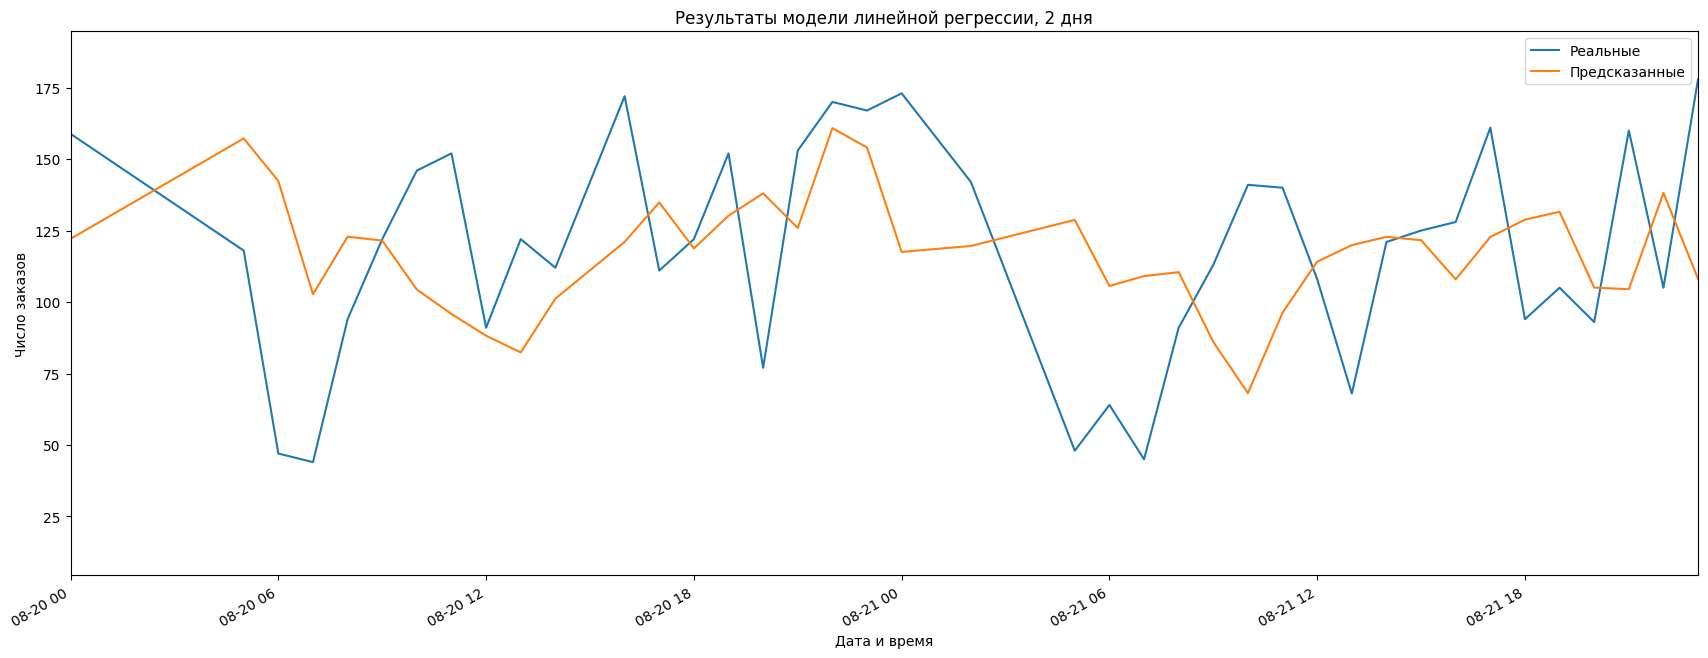

In [178]:
#Построение графиков по реальным и предсказанным данным
df.plot(title = 'Результаты модели линейной регрессии, 2 дня', 
        xlabel='Дата и время', ylabel='Число заказов', 
        figsize=(21,8), 
        xlim=('2018-08-20 00:00:00', '2018-08-21 23:00:00'))

### Модель решающего дерева

In [179]:
##Предсказания модели решающего дерева на тестовой выборке
predict_test_dtr = model_dtr.predict(features_test_dtr)

In [180]:
#RMSE текущей модели на обучающей выборке
print("RMSE обучающей выборки:", mean_squared_error(target_train_dtr, predict_train_dtr) ** 0.5)

RMSE обучающей выборки: 18.315677944149027


In [181]:
#RMSE текущей модели на тестовой выборке
print("RMSE тестовой выборки: ", mean_squared_error(target_test_dtr, predict_test_dtr) ** 0.5)

RMSE тестовой выборки:  38.245760604782944


In [182]:
#Создание датасета с реальными данными целевого признака
df = pd.DataFrame(target_test_dtr)

In [183]:
#Переименование столбца созданного датасета
df = df.rename (columns = {'num_orders': 'Реальные'})

In [184]:
#Добавление к созданному датасету столбца с предсказанными данными
df['Предсказанные']=predict_test_dtr

<Axes: title={'center': 'Результаты модели решающего дерева, 2 дня'}, xlabel='Дата и время', ylabel='Число заказов'>

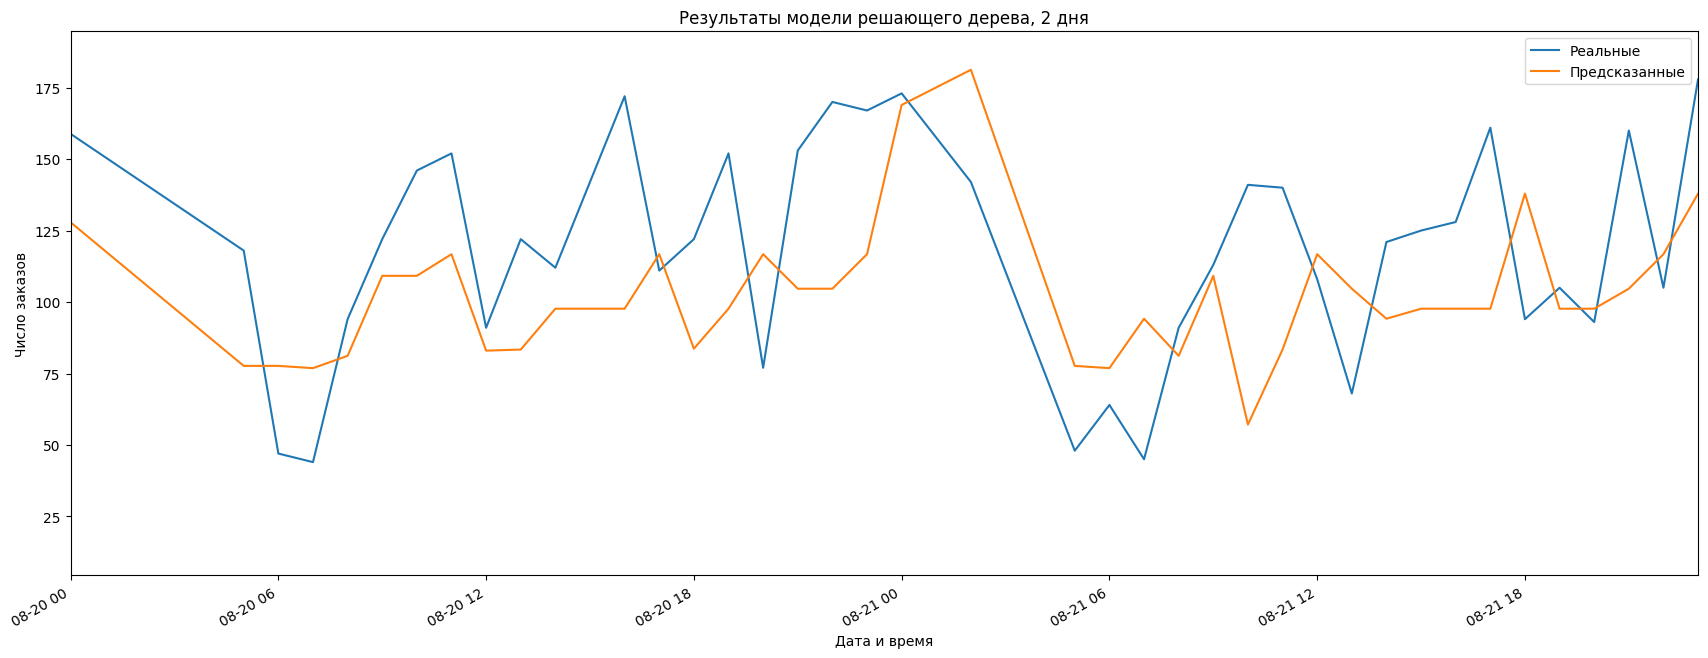

In [185]:
#Построение графиков по реальным и предсказанным данным
df.plot(title = 'Результаты модели решающего дерева, 2 дня', 
        xlabel='Дата и время', 
        ylabel='Число заказов', 
        figsize=(21,8), 
        xlim=('2018-08-20 00:00:00', '2018-08-21 23:00:00'))

### Модель случайного леса

In [186]:
##Предсказания модели случайного леса на тестовой выборке
predict_test_rfr = model_rfr.predict(features_test_rfr)

In [187]:
#RMSE текущей модели на обучающей выборке
print("RMSE обучающей выборки:", mean_squared_error(target_train_rfr, predict_train_rfr) ** 0.5)

RMSE обучающей выборки: 8.83528170290553


In [188]:
#RMSE текущей модели на тестовой выборке
print("RMSE тестовой выборки: ", mean_squared_error(target_test_rfr, predict_test_rfr) ** 0.5)

RMSE тестовой выборки:  35.77868863278742


In [189]:
#Создание датасета с реальными данными целевого признака
df = pd.DataFrame(target_test_rfr)

In [190]:
#Переименование столбца созданного датасета
df = df.rename (columns = {'num_orders': 'Реальные'})

In [191]:
#Добавление к созданному датасету столбца с предсказанными данными
df['Предсказанные']=predict_test_rfr

<Axes: title={'center': 'Результаты модели случайного леса, 2 дня'}, xlabel='Дата и время', ylabel='Число заказов'>

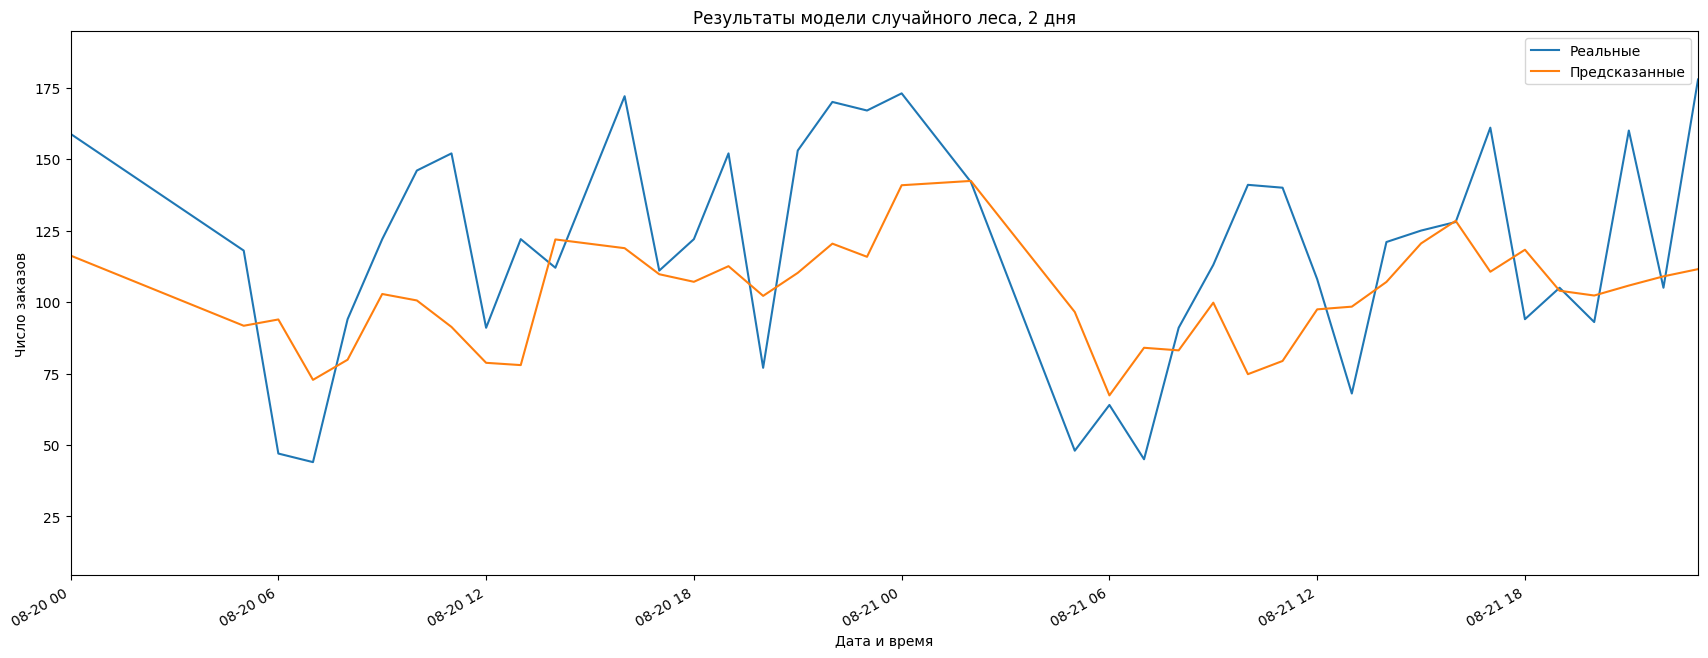

In [192]:
#Построение графиков по реальным и предсказанным данным
df.plot(title = 'Результаты модели случайного леса, 2 дня', 
        xlabel='Дата и время', 
        ylabel='Число заказов', 
        figsize=(21,8), 
        xlim=('2018-08-20 00:00:00', '2018-08-21 23:00:00'))

### Модель CatBoostRegressor

In [193]:
##Предсказания модели CatBoostRegressor на тестовой выборке
predict_test_cbr = model_cbr.predict(features_test_cbr)

In [194]:
#RMSE текущей модели на обучающей выборке
print("RMSE обучающей выборки:", mean_squared_error(target_train_cbr, predict_train_cbr) ** 0.5)

RMSE обучающей выборки: 9.367658018558576


In [195]:
#RMSE текущей модели на тестовой выборке
print("RMSE тестовой выборки: ", mean_squared_error(target_test_cbr, predict_test_cbr) ** 0.5)

RMSE тестовой выборки:  32.73903729901762


In [196]:
#Создание датасета с реальными данными целевого признака
df = pd.DataFrame(target_test_cbr)

In [197]:
#Переименование столбца созданного датасета
df = df.rename (columns = {'num_orders': 'Реальные'})

In [198]:
#Добавление к созданному датасету столбца с предсказанными данными
df['Предсказанные']=predict_test_cbr

<Axes: title={'center': 'Результаты модели CatBoostRegressor, 2 дня'}, xlabel='Дата и время', ylabel='Число заказов'>

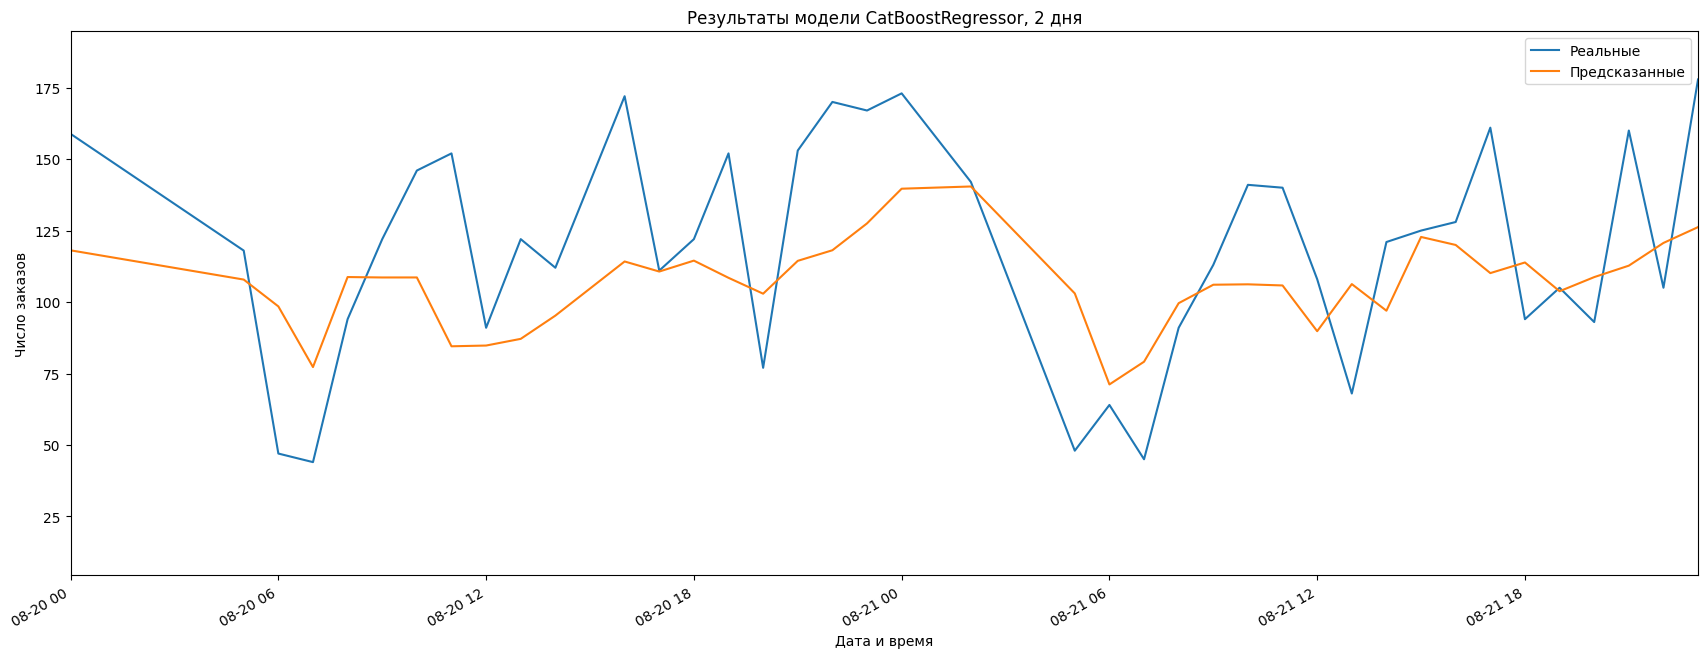

In [199]:
#Построение графиков по реальным и предсказанным данным
df.plot(title = 'Результаты модели CatBoostRegressor, 2 дня', 
        xlabel='Дата и время', 
        ylabel='Число заказов', 
        figsize=(21,8), xlim=('2018-08-20 00:00:00', '2018-08-21 23:00:00'))


### Вывод

Наилучшее значение RMSE на тестовой выборке получается у модели CatBoostRegressor и модели случайного леса. Наихудшее значение RMSE получается у модели линейной регрессии и модели решающего дерева.

## Вывод

Было обучено и протестировано несколько моделей. Наилучшей оказалась модель CatBoostRegressor, которая показала RMSE = 32.739